# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [1]:
import csv
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

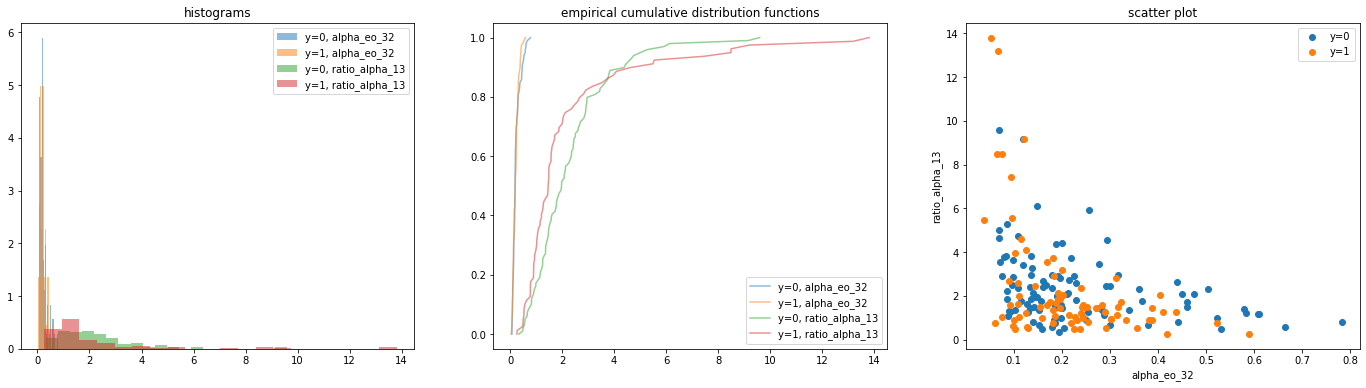

In [3]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

# Creating a dataframe to work

In [4]:
df = pd.DataFrame(X,columns=feature_names)
df['target'] = y
df.iloc[90:110]

,alpha_ec_0,alpha_ec_1,alpha_ec_2,alpha_ec_3,alpha_ec_4,alpha_ec_5,alpha_ec_6,alpha_ec_7,alpha_ec_8,alpha_ec_9,...,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47,target
90,0.34463,0.39558,0.42406,0.35780,0.30858,0.33669,0.36605,0.41847,0.43004,0.451170,...,1.47870,0.97104,0.93881,1.46740,1.70570,1.14420,1.22010,1.30420,1.14000,0.0
91,0.37442,0.35611,0.35561,0.49004,0.37352,0.32263,0.30612,0.31310,0.32177,0.343150,...,0.25651,0.37949,0.31330,0.36740,0.29848,0.44232,0.53238,0.44472,0.36143,0.0
92,0.52675,0.51796,0.50397,0.49213,0.40055,0.34392,0.32608,0.29775,0.31145,0.574190,...,0.78742,0.78272,0.35353,0.29829,0.47447,0.34141,0.44668,0.56536,0.43557,0.0
93,0.76628,0.75440,0.69259,0.65256,0.74414,0.74040,0.74333,0.74962,0.71399,0.365530,...,0.74009,1.04930,0.48940,0.72173,0.72990,0.61948,0.95930,0.72483,0.79829,0.0
94,0.28328,0.36639,0.36632,0.16421,0.27121,0.36659,0.37291,0.36419,0.34203,0.243070,...,2.82590,2.98220,1.79430,1.88380,2.38930,2.66800,2.94930,3.42450,1.53700,0.0
95,0.36459,0.36438,0.37577,0.40028,0.37738,0.37021,0.37350,0.39194,0.39797,0.383790,...,0.63366,0.88072,1.16220,0.96521,0.64491,0.95642,0.90684,0.66988,0.45246,0.0
96,0.54504,0.54544,0.58897,0.56190,0.38313,0.40036,0.40101,0.42762,0.42500,0.655890,...,1.54970,1.46650,2.06940,1.34350,1.15270,1.62230,1.33290,1.09120,1.88340,0.0
97,0.60018,0.57467,0.57240,0.49266,0.45219,0.42779,0.43234,0.42834,0.48265,0.532940,...,1.25990,0.77358,0.39504,0.62554,1.05540,0.40537,0.60164,0.96510,1.68550,0.0
98,0.53837,0.56740,0.56819,0.43262,0.42035,0.38685,0.36907,0.40822,0.50001,0.542260,...,0.60166,0.80679,0.36921,0.33981,0.39026,0.52030,0.66228,0.67321,0.94943,0.0
99,0.41049,0.41977,0.43251,0.35985,0.37236,0.36405,0.37374,0.40909,0.44641,0.397840,...,0.81969,0.92871,0.37871,0.32252,0.50891,0.49298,0.67452,0.50461,0.80480,0.0


# Finding the count of target variables

0.0    100
1.0     80
Name: target, dtype: int64


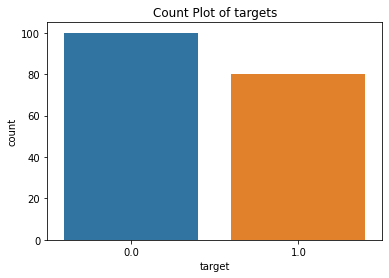

In [5]:
print(df['target'].value_counts())
ax = sns.countplot(data= df, x = "target").set_title('Count Plot of targets')


# Number of Features before reduction

In [6]:
print("The number of dimensions before reduction = ",len(feature_names))

The number of dimensions before reduction =  432


#### Check the datatypes of the features

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Columns: 433 entries, alpha_ec_0 to target
dtypes: float64(433)
memory usage: 609.0 KB
None


All the features are numeric, so we don't have to worry about handling categorical features

#### Lets get more info about the data

In [8]:
df.describe()

,alpha_ec_0,alpha_ec_1,alpha_ec_2,alpha_ec_3,alpha_ec_4,alpha_ec_5,alpha_ec_6,alpha_ec_7,alpha_ec_8,alpha_ec_9,...,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47,target
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,...,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,0.403767,0.406051,0.404508,0.378024,0.370230,0.363051,0.363476,0.369076,0.377025,0.384056,...,1.018505,0.987059,0.982096,1.037945,0.971646,0.988384,1.019272,0.969618,1.081742,0.444444
std,0.212651,0.208703,0.203369,0.207096,0.194484,0.188324,0.186206,0.186509,0.188557,0.195015,...,0.786103,0.748024,0.774820,0.913907,0.782806,0.736152,0.754223,0.766757,0.683975,0.498290
min,0.045305,0.052493,0.064302,0.045197,0.052021,0.054035,0.058347,0.059784,0.066457,0.065896,...,0.150610,0.181840,0.156700,0.175150,0.129730,0.163480,0.221970,0.186500,0.202360,0.000000
25%,0.240980,0.249483,0.258088,0.209325,0.209490,0.198185,0.205645,0.216885,0.219768,0.238817,...,0.567813,0.544520,0.478085,0.478295,0.502760,0.500135,0.539732,0.503912,0.619140,0.000000
50%,0.377190,0.384445,0.390135,0.358825,0.372940,0.360960,0.364725,0.370520,0.370055,0.359725,...,0.795555,0.833965,0.693510,0.788905,0.751085,0.740230,0.757965,0.733035,0.907780,0.000000
75%,0.540840,0.541517,0.544342,0.511320,0.503810,0.486233,0.484110,0.500715,0.504252,0.519500,...,1.266450,1.170825,1.161300,1.311050,1.158325,1.161850,1.202875,1.097800,1.301550,1.000000
max,0.991070,0.952930,0.950500,0.998370,0.914860,0.893100,0.881890,0.847760,0.829670,0.987760,...,6.624000,6.733600,4.496800,6.669300,5.561000,3.959300,4.450900,5.353900,5.352300,1.000000


#### Lets check for null values

In [9]:
print(df.isnull().sum())
print("\nNull values : ",df.isnull().values.any())

alpha_ec_0        0
alpha_ec_1        0
alpha_ec_2        0
alpha_ec_3        0
alpha_ec_4        0
                 ..
ratio_theta_44    0
ratio_theta_45    0
ratio_theta_46    0
ratio_theta_47    0
target            0
Length: 433, dtype: int64

Null values :  False


# Model before dimensionality reduction

### Lets split the train and test data

In [10]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y = np.ravel(df.iloc[:,-1:])

#### Necessary imports

In [11]:
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, LeaveOneOut, LeaveOneGroupOut
from sklearn.metrics import roc_auc_score,recall_score, accuracy_score , classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

#### Lets get the mean and std of accuracy using Leave one group out cross validation

In [12]:
group = []
for i in range(1,19):
    group.append(np.array(10 * [i]))
group = np.array(group).reshape(180,)

clf = LogisticRegression(solver='lbfgs',max_iter=1000)
scaler = StandardScaler()
pipe = make_pipeline(scaler,clf)
cv_scores = cross_val_score(clf, X, y, cv = LeaveOneGroupOut().split(X,y,groups = group))
print("The mean accuracy is {} and the standard deviation is {}".format(np.mean(cv_scores), np.std(cv_scores)))

The mean accuracy is 0.8555555555555556 and the standard deviation is 0.13425606637327303


In [13]:
#This method is manual method to calculate accuracy, recall and specificity

def get_cr(X,y,n):
    logo = LeaveOneGroupOut()
    logo.get_n_splits(X, y, group)
    logo.get_n_splits(groups=group)  # 'groups' is always required
    accuracy = []
    pred = []
    clf = LogisticRegression(solver='lbfgs',max_iter=1000)
    #clf = KNeighborsClassifier(n_neighbors=n)
    #clf = GaussianNB()
    #clf = DecisionTreeClassifier()
    for train_index, test_index in logo.split(X, y, group):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #X_train = scaler.fit_transform(X_train)
        #X_test = scaler.transform(X_test)
        clf = clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        pred.append(y_pred)
        accuracy.append(accuracy_score(y_test,y_pred))
        
    pred = np.array(pred)
    pred = pred.reshape(-1,1)

    print("\t\t\tClassification report \n\n",classification_report(y, pred))
    cm = confusion_matrix(y,pred)
    TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    print("\nConfusion Matrix \n\n",cm)
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    print("\nThe Accuracy : ",np.mean(accuracy))
    print('The sensitivity : {} \nThe specificity : {}'.format(recall_score(y,pred),specificity))
    print("\nThe standard deviation of The Accuracy : ",np.std(accuracy))    

In [14]:
get_cr(X,y,1)

			Classification report 

               precision    recall  f1-score   support

         0.0       0.86      0.88      0.87       100
         1.0       0.85      0.82      0.84        80

    accuracy                           0.86       180
   macro avg       0.85      0.85      0.85       180
weighted avg       0.86      0.86      0.86       180


Confusion Matrix 

 [[88 12]
 [14 66]]

The Accuracy :  0.8555555555555556
The sensitivity : 0.825 
The specificity : 0.88

The standard deviation of The Accuracy :  0.13425606637327303


# Lets do some Dimensionality Reduction
### First lets try with Filter method

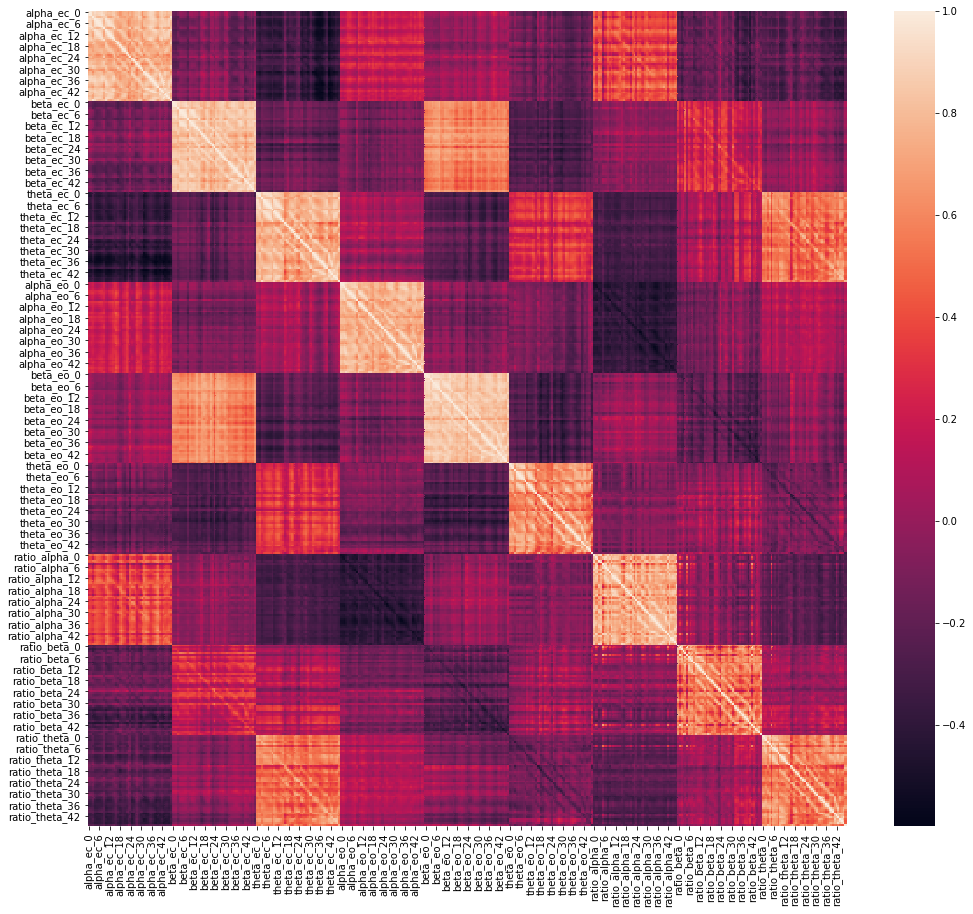

In [15]:
plt.figure(figsize=(17,15))
cor = X.corr()
ax = sns.heatmap(cor)

#### Pearson Correlation

In [16]:
features = set()
for i in range(len(cor.columns)):
    for j in range(i):
        if (cor.iloc[i, j]) > 0.90:
            colname = cor.columns[i]
            features.add(colname)
print("The number of features to be reduced" , len(features))            

The number of features to be reduced 243


In [17]:
X_copy = X.copy()
X_copy.drop(labels=features, axis=1, inplace=True)

In [18]:
get_cr(X_copy,y,1)
print("\nUsing Standard Scaler")
cv_scores = cross_val_score(pipe,X_copy, y, cv = LeaveOneGroupOut().split(X_copy,y,groups = group))
print("The mean accuracy is {} and the standard deviation is {}".format(np.mean(cv_scores), np.std(cv_scores)))

			Classification report 

               precision    recall  f1-score   support

         0.0       0.87      0.86      0.86       100
         1.0       0.83      0.84      0.83        80

    accuracy                           0.85       180
   macro avg       0.85      0.85      0.85       180
weighted avg       0.85      0.85      0.85       180


Confusion Matrix 

 [[86 14]
 [13 67]]

The Accuracy :  0.8500000000000001
The sensitivity : 0.8375 
The specificity : 0.86

The standard deviation of The Accuracy :  0.12583057392117916

Using Standard Scaler
The mean accuracy is 0.8722222222222223 and the standard deviation is 0.1145307118227128


#### Chi squared

In [19]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

select_k = 120
  
selection = SelectKBest(chi2, k=select_k).fit(X, y)

features = X.columns[selection.get_support()]
X_chi = X[features]
get_cr(X_chi,y,1)

			Classification report 

               precision    recall  f1-score   support

         0.0       0.86      0.83      0.85       100
         1.0       0.80      0.84      0.82        80

    accuracy                           0.83       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.83      0.83      0.83       180


Confusion Matrix 

 [[83 17]
 [13 67]]

The Accuracy :  0.8333333333333335
The sensitivity : 0.8375 
The specificity : 0.83

The standard deviation of The Accuracy :  0.11547005383792516


#### Anova test

In [20]:
selection = SelectKBest(f_classif, k=325).fit(X, y)
features = X.columns[selection.get_support()]
X_anova = X[features]
get_cr(X_anova,y,1)

			Classification report 

               precision    recall  f1-score   support

         0.0       0.87      0.84      0.85       100
         1.0       0.81      0.84      0.82        80

    accuracy                           0.84       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.84      0.84      0.84       180


Confusion Matrix 

 [[84 16]
 [13 67]]

The Accuracy :  0.8388888888888889
The sensitivity : 0.8375 
The specificity : 0.84

The standard deviation of The Accuracy :  0.1253390463630942


#### Mutual gain

In [21]:
selection = SelectKBest(mutual_info_classif, k=180).fit(X, y)
features = X.columns[selection.get_support()]
X_mi = X[features]
print(get_cr(X_mi,y,1))

			Classification report 

               precision    recall  f1-score   support

         0.0       0.90      0.86      0.88       100
         1.0       0.83      0.88      0.85        80

    accuracy                           0.87       180
   macro avg       0.86      0.87      0.87       180
weighted avg       0.87      0.87      0.87       180


Confusion Matrix 

 [[86 14]
 [10 70]]

The Accuracy :  0.8666666666666667
The sensitivity : 0.875 
The specificity : 0.86

The standard deviation of The Accuracy :  0.13743685418725535
None


#### Using standard scaler to scale and checking the accuracy

In [22]:
cv_scores = cross_val_score(pipe,X_mi, y, cv = LeaveOneGroupOut().split(X_mi,y,groups = group))
print("The mean accuracy is {} and the standard deviation is {}".format(np.mean(cv_scores), np.std(cv_scores)))

The mean accuracy is 0.9222222222222223 and the standard deviation is 0.0785674201318386


### Feature reduction using filter methods, degrades the performance than increasing it, so lets try wrapper method

#### Forward Feature selection

In [23]:
from mlxtend.feature_selection import SequentialFeatureSelector

sbs = SequentialFeatureSelector(LogisticRegression(solver='lbfgs',max_iter=1000), 
           k_features=180, 
           forward=True, 
           floating=False,
           verbose=2,
           scoring='roc_auc',
           cv=2)

sbs = sbs.fit(X, y)

selected_features = X.columns[list(sbs.k_feature_idx_)]
print(selected_features)

print(sbs.k_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:    2.4s finished

[2021-04-05 18:24:09] Features: 1/180 -- score: 0.78075[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 431 out of 431 | elapsed:    2.6s finished

[2021-04-05 18:24:11] Features: 2/180 -- score: 0.819[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 430 out of 430 | elapsed:    2.9s finished

[2021-04-05 18:24:14] Features: 3/180 -- score: 0.84875[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s

[Parallel(n_jobs=1)]: Done 404 out of 404 | elapsed:    4.2s finished

[2021-04-05 18:26:03] Features: 29/180 -- score: 0.95475[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 403 out of 403 | elapsed:    4.0s finished

[2021-04-05 18:26:07] Features: 30/180 -- score: 0.9550000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:    4.1s finished

[2021-04-05 18:26:11] Features: 31/180 -- score: 0.9555[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 401 out of 401 | elapsed:    4.1s finished

[2021-04-05 18:26:15] Features: 32/180 -- score: 0.9557

[Parallel(n_jobs=1)]: Done 376 out of 376 | elapsed:    4.2s finished

[2021-04-05 18:28:07] Features: 57/180 -- score: 0.9577500000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:    4.2s finished

[2021-04-05 18:28:11] Features: 58/180 -- score: 0.9577500000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 374 out of 374 | elapsed:    4.1s finished

[2021-04-05 18:28:15] Features: 59/180 -- score: 0.9577500000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 373 out of 373 | elapsed:    4.2s finished

[2021-04-05 18:28:19] Features: 

[Parallel(n_jobs=1)]: Done 347 out of 347 | elapsed:    4.4s finished

[2021-04-05 18:30:16] Features: 86/180 -- score: 0.97125[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 346 out of 346 | elapsed:    4.5s finished

[2021-04-05 18:30:21] Features: 87/180 -- score: 0.9715[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    4.5s finished

[2021-04-05 18:30:25] Features: 88/180 -- score: 0.9715[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 344 out of 344 | elapsed:    4.4s finished

[2021-04-05 18:30:30] Features: 89/180 -- score: 0.97175[Parallel(n

[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:   10.5s finished

[2021-04-05 18:33:38] Features: 114/180 -- score: 0.97275[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 318 out of 318 | elapsed:   10.6s finished

[2021-04-05 18:33:49] Features: 115/180 -- score: 0.97275[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 317 out of 317 | elapsed:   10.5s finished

[2021-04-05 18:34:00] Features: 116/180 -- score: 0.97275[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 316 out of 316 | elapsed:   10.7s finished

[2021-04-05 18:34:11] Features: 117/180 -- score: 0.97275[Para

[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:   10.0s finished

[2021-04-05 18:38:48] Features: 143/180 -- score: 0.9730000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 289 out of 289 | elapsed:    9.9s finished

[2021-04-05 18:38:58] Features: 144/180 -- score: 0.9730000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:   10.2s finished

[2021-04-05 18:39:09] Features: 145/180 -- score: 0.9730000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 287 out of 287 | elapsed:   10.0s finished

[2021-04-05 18:39:19] Feature

[Parallel(n_jobs=1)]: Done 262 out of 262 | elapsed:    9.4s finished

[2021-04-05 18:43:25] Features: 171/180 -- score: 0.9737500000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 261 out of 261 | elapsed:    9.3s finished

[2021-04-05 18:43:35] Features: 172/180 -- score: 0.9737500000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    9.4s finished

[2021-04-05 18:43:44] Features: 173/180 -- score: 0.9737500000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 259 out of 259 | elapsed:    9.5s finished

[2021-04-05 18:43:54] Feature

Index(['alpha_ec_16', 'beta_ec_0', 'beta_ec_1', 'beta_ec_2', 'beta_ec_3',
       'beta_ec_4', 'beta_ec_5', 'beta_ec_6', 'beta_ec_7', 'beta_ec_8',
       ...
       'ratio_beta_32', 'ratio_beta_34', 'ratio_beta_43', 'ratio_beta_44',
       'ratio_beta_45', 'ratio_beta_46', 'ratio_theta_7', 'ratio_theta_8',
       'ratio_theta_28', 'ratio_theta_40'],
      dtype='object', length=180)
0.9735


[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:    9.3s finished

[2021-04-05 18:44:51] Features: 180/180 -- score: 0.9735

In [24]:
X_frwd = X[selected_features]
get_cr(X_frwd,y,1)
print("\nUsing Standard Scaler")
cv_scores = cross_val_score(pipe,X_frwd, y, cv = LeaveOneGroupOut().split(X_frwd,y,groups = group))
print("The mean accuracy is {} and the standard deviation is {}".format(np.mean(cv_scores), np.std(cv_scores)))

			Classification report 

               precision    recall  f1-score   support

         0.0       0.83      0.93      0.88       100
         1.0       0.90      0.76      0.82        80

    accuracy                           0.86       180
   macro avg       0.86      0.85      0.85       180
weighted avg       0.86      0.86      0.85       180


Confusion Matrix 

 [[93  7]
 [19 61]]

The Accuracy :  0.8555555555555556
The sensitivity : 0.7625 
The specificity : 0.93

The standard deviation of The Accuracy :  0.13833221775543036

Using Standard Scaler
The mean accuracy is 0.9499999999999998 and the standard deviation is 0.07637626158259732


#### Normalising the output of Forward selection gives great accuracy, but the sensitivity is less, lets try Backward feature elimination.

In [25]:
sbs = SequentialFeatureSelector(LogisticRegression(solver='lbfgs',max_iter=1000), 
           k_features=180, 
           forward=False, 
           floating=False,
           verbose=1,
           scoring='roc_auc',
           cv=2)

sbs = sbs.fit(X, y)

selected_features_sbs = X.columns[list(sbs.k_feature_idx_)]
print(selected_features_sbs)
print(sbs.k_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:   53.5s finished
Features: 431/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 431 out of 431 | elapsed:   53.9s finished
Features: 430/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 430 out of 430 | elapsed:   54.7s finished
Features: 429/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 429 out of 429 | elapsed:   53.3s finished
Features: 428/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 428 out of 428 | elapsed:   53.7s finished
Features: 427/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 427 out of 427 | elapsed:   53.6s finished
Features:

Features: 383/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 383 out of 383 | elapsed:   43.8s finished
Features: 382/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 382 out of 382 | elapsed:   41.9s finished
Features: 381/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 381 out of 381 | elapsed:   44.4s finished
Features: 380/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:   43.4s finished
Features: 379/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:   43.9s finished
Features: 378/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 378 out of 378 | elapsed:   42.6s f

Features: 334/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 334 out of 334 | elapsed:   35.0s finished
Features: 333/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 333 out of 333 | elapsed:   34.5s finished
Features: 332/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 332 out of 332 | elapsed:   36.7s finished
Features: 331/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 331 out of 331 | elapsed:   34.2s finished
Features: 330/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 330 out of 330 | elapsed:   33.6s finished
Features: 329/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 329 out of 329 | elapsed:   33.2s f

Features: 285/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 285 out of 285 | elapsed:   28.9s finished
Features: 284/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 284 out of 284 | elapsed:   28.6s finished
Features: 283/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 283 out of 283 | elapsed:   28.2s finished
Features: 282/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 282 out of 282 | elapsed:   30.2s finished
Features: 281/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 281 out of 281 | elapsed:   27.7s finished
Features: 280/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:   28.1s f

Features: 236/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 236 out of 236 | elapsed:   23.3s finished
Features: 235/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed:   22.3s finished
Features: 234/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 234 out of 234 | elapsed:   21.5s finished
Features: 233/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 233 out of 233 | elapsed:   23.0s finished
Features: 232/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 232 out of 232 | elapsed:   26.4s finished
Features: 231/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 231 out of 231 | elapsed:   25.5s f

Features: 187/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:   34.4s finished
Features: 186/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 186 out of 186 | elapsed:   18.8s finished
Features: 185/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 185 out of 185 | elapsed:   16.7s finished
Features: 184/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 184 out of 184 | elapsed:   16.2s finished
Features: 183/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:   16.5s finished
Features: 182/180[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:   16.9s f

Index(['alpha_ec_0', 'alpha_ec_1', 'alpha_ec_3', 'alpha_ec_4', 'alpha_ec_5',
       'alpha_ec_6', 'alpha_ec_7', 'alpha_ec_8', 'alpha_ec_9', 'alpha_ec_10',
       ...
       'ratio_theta_19', 'ratio_theta_20', 'ratio_theta_24', 'ratio_theta_27',
       'ratio_theta_32', 'ratio_theta_33', 'ratio_theta_34', 'ratio_theta_35',
       'ratio_theta_44', 'ratio_theta_45'],
      dtype='object', length=180)
0.988


In [26]:
X_bcwrd = X[selected_features_sbs]
get_cr(X_bcwrd,y,1)
print("\nUsing Standard Scaler")
cv_scores = cross_val_score(pipe,X_bcwrd, y, cv = LeaveOneGroupOut().split(X_bcwrd,y,groups = group))
print("The mean accuracy is {} and the standard deviation is {}".format(np.mean(cv_scores), np.std(cv_scores)))

			Classification report 

               precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       100
         1.0       0.89      0.91      0.90        80

    accuracy                           0.91       180
   macro avg       0.91      0.91      0.91       180
weighted avg       0.91      0.91      0.91       180


Confusion Matrix 

 [[91  9]
 [ 7 73]]

The Accuracy :  0.9111111111111112
The sensitivity : 0.9125 
The specificity : 0.91

The standard deviation of The Accuracy :  0.07370277311900889

Using Standard Scaler
The mean accuracy is 0.9222222222222223 and the standard deviation is 0.08534606386520675


# Embedded methods for feature selection

 #### Lets try L1 regularization with Logistic Regression for feature selection.

In [27]:
#Importing the necessary packages
from sklearn.feature_selection import SelectFromModel

embd_selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))
embd_selector.fit(X, y)

selected_features_embd = X.columns[(embd_selector.get_support())]
print("Number of selected features" , len(selected_features_embd))

Number of selected features 43


In [28]:
X_embedded = X[selected_features_embd]
get_cr(X_embedded,y,1)
print("\nUsing Standard Scaler")
cv_scores = cross_val_score(pipe,X_embedded, y, cv = LeaveOneGroupOut().split(X_embedded,y,groups = group))
print("The mean accuracy is {} and the standard deviation is {}".format(np.mean(cv_scores), np.std(cv_scores)))

			Classification report 

               precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       100
         1.0       0.90      0.88      0.89        80

    accuracy                           0.90       180
   macro avg       0.90      0.90      0.90       180
weighted avg       0.90      0.90      0.90       180


Confusion Matrix 

 [[92  8]
 [10 70]]

The Accuracy :  0.8999999999999999
The sensitivity : 0.875 
The specificity : 0.92

The standard deviation of The Accuracy :  0.0816496580927726

Using Standard Scaler
The mean accuracy is 0.8999999999999999 and the standard deviation is 0.07453559924999299


#### Lets try with Random Forest feature importance

In [34]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

rfc.fit(X, y)

importances = rfc.feature_importances_

In [35]:
rfc_df = pd.DataFrame({"Features": X.columns, "Importances":importances})

In [36]:
impt_features = rfc_df.sort_values('Importances', ascending=False)[:170]['Features']

In [37]:
X_rfc = X[impt_features]
get_cr(X_rfc,y,1)
print("\nUsing Standard Scaler")
cv_scores = cross_val_score(pipe,X_rfc, y, cv = LeaveOneGroupOut().split(X_rfc,y,groups = group))
print("The mean accuracy is {} and the standard deviation is {}".format(np.mean(cv_scores), np.std(cv_scores)))

			Classification report 

               precision    recall  f1-score   support

         0.0       0.89      0.88      0.88       100
         1.0       0.85      0.86      0.86        80

    accuracy                           0.87       180
   macro avg       0.87      0.87      0.87       180
weighted avg       0.87      0.87      0.87       180


Confusion Matrix 

 [[88 12]
 [11 69]]

The Accuracy :  0.8722222222222222
The sensitivity : 0.8625 
The specificity : 0.88

The standard deviation of The Accuracy :  0.09891385452647143

Using Standard Scaler
The mean accuracy is 0.9333333333333333 and the standard deviation is 0.07453559924999298


#### Tree based models are not performing as expected